In [1]:
import pandas as pd
import disaggregator as dis
from disaggregator import data, spatial, plot, config, temporal
import matplotlib.pyplot as plt
import numpy as np

ja in diesem übelst nicen Notebook wird voll mein Code demonstriert und so ey

beim einlesen werden ME(strom) bzw. Raumwärme(gas) angepasst da sie die größten anteile darstellen

In [6]:
def split_on_applications(sector='CTS', source='power'): #**kwargs
    """
    verstellbarkeit/wachstum

    """
    # year = kwargs.get("year", cfg["base_year"])
    
    # reading and preapring the consumption table
    if source == "power":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Strom Test")
    elif source == "gas":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Gas Test")
    else:
        print("'source' needs to be 'power' or 'gas'")
        return
    
    eev_clean = eev.loc[[isinstance(x, int) for x in eev["WZ"]]] # nur die WZ
    # use WZ as index for further operations
    eev_clean = eev_clean.set_index("WZ")

    if sector == "CTS":
        ec = spatial.disagg_CTS_industry(source, sector, use_nuts3code = True) # year = year
    elif sector == "industry":
        ec = spatial.disagg_CTS_industry(source, sector, use_nuts3code = True) # year = year
    else:
        print("'sector' must be 'CTS' or 'industry'")
        return
        
    usage = eev_clean.loc[ec.index]

    # for better acces
    ec = ec.T
    
    # creating the multiindex
    multi_wz = [elem for elem in list(ec.columns) for _ in range(len(eev_clean.columns))]
    multi_app = list(usage.columns[:]) * len(usage.index)
    
    tuples = list(zip(*[multi_wz, multi_app]))
    columns = pd.MultiIndex.from_tuples(tuples, names = ["WZ", "VW"])
    
    new_df = pd.DataFrame(columns = columns, index = ec.index)
    
    for wz in new_df.columns.get_level_values(0).unique():
        for app in new_df.columns.get_level_values(1).unique():
            percent = usage.loc[wz, app]
            new_df[wz, app] = ec[wz] * percent
            
    # Plausibility check:
    msg = ('The sum of consumptions (={:.3f}) and the sum of disaggrega'
           'ted consumptions (={:.3f}) do not match! Please check algorithm!')
    total_sum = ec.sum().sum()
    disagg_sum = new_df.sum().sum()
    assert np.isclose(total_sum, disagg_sum), msg.format(total_sum, disagg_sum)
    
    
    return new_df

In [8]:
ec_industry = split_on_applications(source = "power", sector = "industry")
ec_industry.head()

WZ             5                                                      \
VW    Beleuchtung  IKT Klimakälte Prozesskälte Mechanische \nEnergie   
DEF01         0.0  0.0        0.0          0.0                   0.0   
DEF02         0.0  0.0        0.0          0.0                   0.0   
DEF03         0.0  0.0        0.0          0.0                   0.0   
DEF04         0.0  0.0        0.0          0.0                   0.0   
DEF05         0.0  0.0        0.0          0.0                   0.0   

WZ                                                6                ...  \
VW    Prozesswärme Raumwärme Warmwasser  Beleuchtung          IKT  ...   
DEF01          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF02          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF03          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF04          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF05          0.0       0.0        0.0  2737.665436  2494.317397  ...   

WZ             32                       33                           \
VW      Raumwärme  Warmwasser  Beleuchtung          IKT  Klimakälte   
DEF01   10.437518    6.958345    68.643652    89.694371   21.050720   
DEF02   23.551322   15.700881   389.771283   509.301144  119.529860   
DEF03  264.751652  176.501101   358.322745   468.208386  109.885642   
DEF04   29.974410   19.982940   153.430750   200.482846   47.052097   
DEF05    7.560510    5.040340  1798.581730  2350.146794  551.565064   

WZ                                                                            
VW    Prozesskälte Mechanische \nEnergie Prozesswärme   Raumwärme Warmwasser  
DEF01     6.406741            455.793847    69.558900    5.491492   3.660995  
DEF02    36.378653           2588.081321   394.968234   31.181703  20.787802  
DEF03    33.443456           2379.263024   363.100381   28.665820  19.110546  
DEF04    14.320203           1018.780178   155.476493   12.274460   8.182973  
DEF05   167.867628          11942.582686  1822.562820  143.886538  95.924359  

[5 rows x 232 columns]

In [9]:
# der hat noch probleme mit plausibilität, alle andere funktionieren
split_on_applications(source = "gas", sector = "industry")

AssertionError: The sum of consumptions (=303448557.097) and the sum of disaggregated consumptions (=303084523.868) do not match! Please check algorithm!

ja lol entwerder man guckt sich die Summe über alle an 

In [10]:
ec_industry_applications = ec_industry.groupby("VW", axis = 1).sum()/1000
ec_industry_applications.head()

VW,Beleuchtung,IKT,Klimakälte,Mechanische \nEnergie,Prozesskälte,Prozesswärme,Raumwärme,Warmwasser
DEF01,4.589563,4.894792,2.489023,69.136599,3.940820,9.667805,0.349218,0.232812
DEF02,12.356891,12.794354,4.789209,113.120029,4.862297,15.387444,0.937118,0.624745
DEF03,12.593906,14.656007,5.963181,145.656661,11.950131,27.162035,0.974467,0.649645
DEF04,6.812981,6.804998,2.767980,83.164448,3.494442,17.256733,0.514712,0.343141
DEF05,25.922834,26.993871,16.421573,603.813295,77.791211,195.410880,1.938415,1.292276


C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Fabian\Code\disaggregator\disaggregator\plot.py:202: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be d

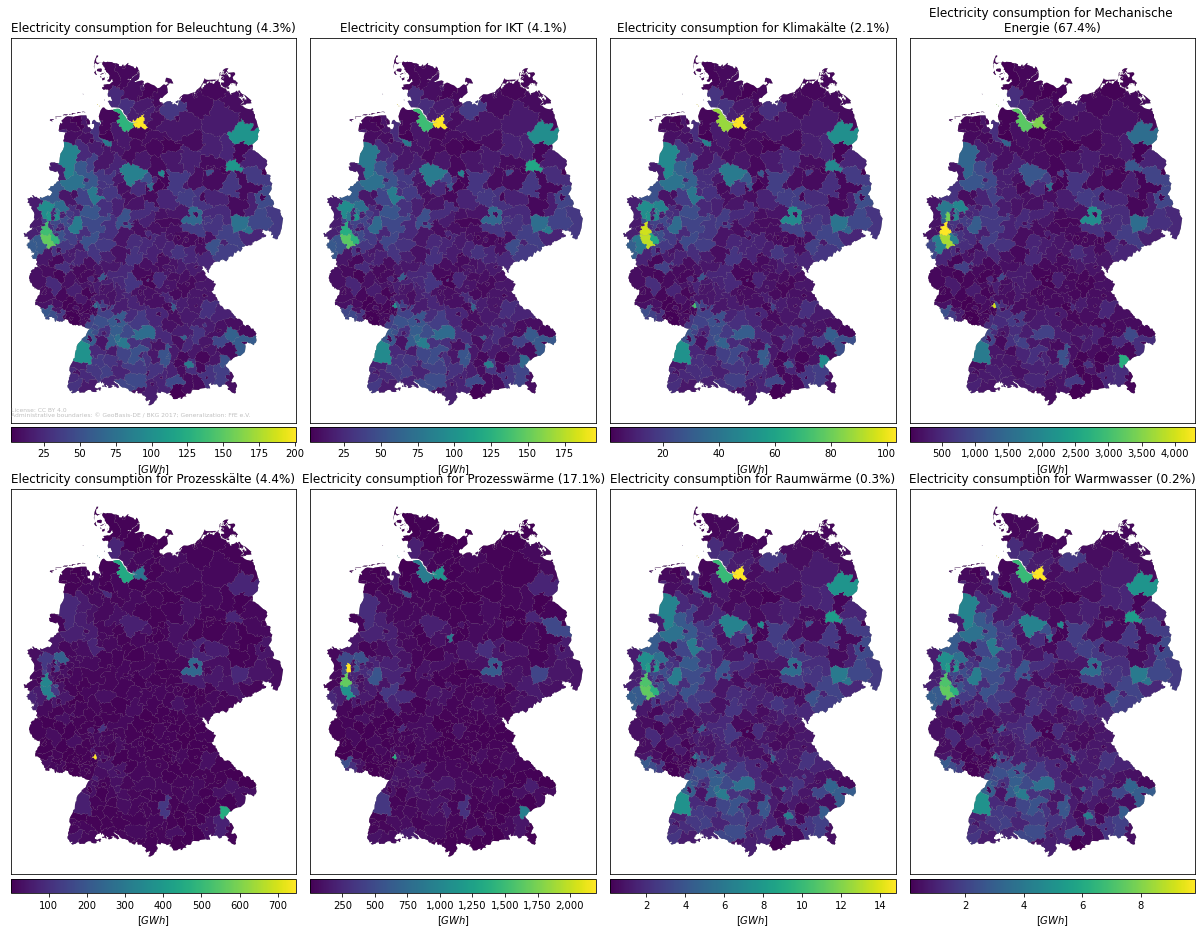

In [12]:
fig, ax = plot.choropleth_map(ec_industry_applications, relative=False, unit='GWh', axtitle='Electricity consumption for', 
                              colorbar_each_subplot=True,  add_percentages=True)

oder man wählt sich einen spezifischen WZ aus

C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Fabian\Code\disaggregator\disaggregator\plot.py:202: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be d

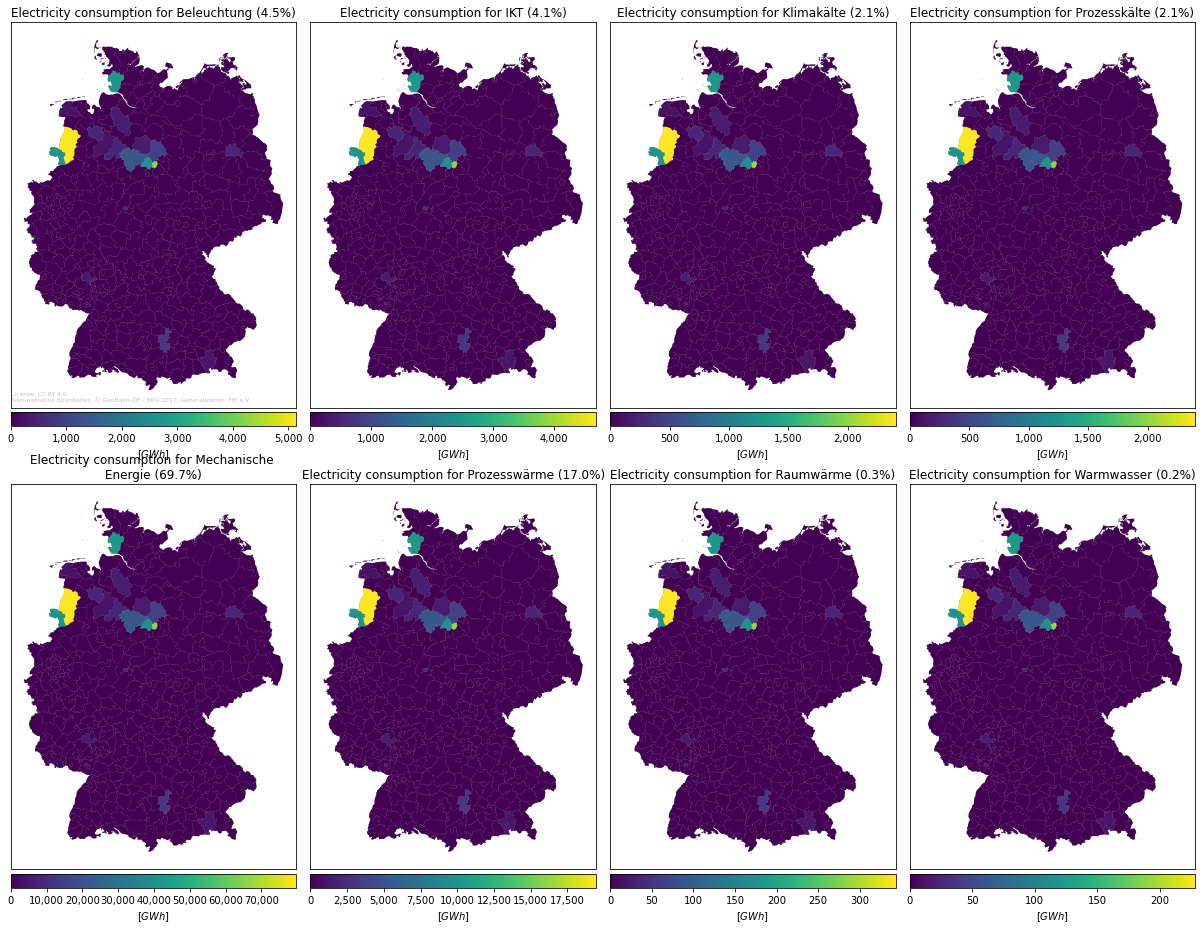

In [13]:
fig, ax = plot.choropleth_map(ec_industry[6], relative=False, unit='GWh', axtitle='Electricity consumption for', 
                              colorbar_each_subplot=True,  add_percentages=True)

## der zeitliche Spaß

In [14]:
def temporal_split_on_applications(df, wz = None, source = "power", sector = "industry"):
    """
    verschiebbarkeit
    plausibility check
    """
    # variable check
    assert source in ["power", "gas"], "'source' needs to be 'power' or 'gas'"
    assert sector in ["CTS", "industry"], "'sector' needs to be 'CTS' or 'industry'"
    
    # reading and preapring the consumption table
    if source == "power":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Strom Test")
    if source == "gas":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Gas Test")
    
    eev_clean = eev.loc[[isinstance(x, int) for x in eev["WZ"]]] # nur die WZ
    # use WZ as index for further operations
    eev_clean = eev_clean.set_index("WZ")
    
    # if there are 4 or 8 different applications
    amount_application = len(eev_clean.columns)
    
    # check if WZ are grouped together
    if df.columns.nlevels == 1:
        ### aktuell noch nicht schön
        if source == "power":
            # ec cts hat aktuel 1.01 summe
            if sector == "CTS": percentages = {"Beleuchtung": 0.326, "IKT": 0.151, "Klimakälte": 0.019, "Mechanische \nEnergie": 0.307, "Prozesskälte": 0.077, "Prozesswärme": 0.049, "Raumwärme": 0.037, "Warmwasser": 0.035}
            if sector == "industry": percentages = {"Beleuchtung": 0.043, "IKT": 0.041, "Klimakälte": 0.021, "Mechanische \nEnergie": 0.674, "Prozesskälte": 0.044, "Prozesswärme": 0.172, "Raumwärme": 0.003, "Warmwasser": 0.002}
        if source == "gas":
            if sector == "CTS": percentages = {"Mechanische \nEnergie": 0.045, "Prozesswärme": 0.102, "Raumwärme": 0.805, "Warmwasser": 0.048}
            # gc industry ändert sich evtl durch plausibilität anpassungen
            if sector == "industry": percentages = {"Mechanische \nEnergie": 0.028, "Prozesswärme": 0.693, "Raumwärme": 0.269, "Warmwasser": 0.01}
        
        # creating the multiindex
        multi_lk = [elem for elem in list(df.columns) for _ in range(amount_application)]
        multi_app = list(eev_clean.columns) * len(df.columns)
        #multi_app = list(CTS_applications["Application"].unique()) * len(df.columns)
        tuples = list(zip(*[multi_lk, multi_app]))
        index = pd.MultiIndex.from_tuples(tuples, names = ["LK", "VW"])
        # new df with multiindex columns and datetime as index
        new_df = pd.DataFrame(columns = index, index = df.index)
        
        # for every lk multiply the consumption with the percentual use for that application
        for lk in df.columns:
            for app in eev_clean.columns:
            #for app in CTS_applications["Application"].unique():
                percent = percentages[app]
                new_df[lk, app] = percent * df[lk]
    
    
    # check if evaluating for every WZ
    elif df.columns.nlevels == 2:
        ## do somethin different
        # check if the WZ is in the df
        #assert (wz in df.columns.get_level_values(1).unique()), "the specified WZ is not in the dataframe"        
        if isinstance(wz, int):
            wz = [wz]
        else:
            assert isinstance(wz, list), "'wz' needs to be an integer or a list."
            
        #assert isinstance(wz, list), "WZ needs to be a list."
        # overwrite eev_clean with only the necesarry wz to save ram
        try:
            eev_clean = eev_clean.loc[wz]
        except:
            raise AssertionError("the specified WZ is/are not in the input dataframe")

        # creating the multiindex
        #multi_lk = list(df.columns.get_level_values(0).unique()) * len(wz) * 8
        multi_lk = [elem for elem in list(df.columns.get_level_values(0).unique()) for _ in range(amount_application * len(wz))]
        # 
        multi_wz = [elem for elem in wz for _ in range(amount_application)] * 401
        multi_app = list(eev_clean.columns) * 401 * len(wz)
        #multi_app = list(CTS_applications["Application"].unique()) * len(df.columns)
        tuples = list(zip(*[multi_lk, multi_wz, multi_app]))
        columns = pd.MultiIndex.from_tuples(tuples, names = ["LK", "WZ", "VW"])
        
        # new df with multiindex columns and datetime as index
        new_df = pd.DataFrame(columns = columns, index = df.index)
        
        # sort index for faster lookup in value multiplication
        # new_df.sort_index()
        
        
        # for every lk and WZ multiply the consumption with the percentual use for that application
        for lk in new_df.columns.get_level_values(0).unique():
            for wz in new_df.columns.get_level_values(1).unique():
                for app in new_df.columns.get_level_values(2).unique():
                    percent = eev_clean.loc[wz, app]
                    new_df[lk, wz, app] = percent * df[lk, wz]
        
    else:
        print("The input df needs to have either the LK as columns or a multiindex witch LK and VW")
        return
    return new_df

zu erst müssen die zeitlichen Folgen erstellt werden

In [15]:
temp_power_CTS = temporal.disagg_temporal_power_CTS(use_nuts3code = True)

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

man sieht der Spaß funktioniert mit den simplen Versionen wo über alle WZ aggregiert wurde

In [16]:
simple_power_CTS_time = temporal_split_on_applications(temp_power_CTS, source = "power")
simple_power_CTS_time.head()

LK                        DEF01                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.131531  0.125413   0.064236     0.134590   
2015-01-01 00:15:00    0.138206  0.131778   0.067496     0.141420   
2015-01-01 00:30:00    0.134533  0.128276   0.065702     0.137662   
2015-01-01 00:45:00    0.131309  0.125202   0.064128     0.134363   
2015-01-01 01:00:00    0.128903  0.122908   0.062953     0.131901   

LK                                                                           \
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              2.061674     0.526124  0.009177   0.006118   
2015-01-01 00:15:00              2.166294     0.552823  0.009642   0.006428   
2015-01-01 00:30:00              2.108734     0.538134  0.009386   0.006257   
2015-01-01 00:45:00              2.058195     0.525237  0.009161   0.006107   
2015-01-01 01:00:00              2.020482     0.515613  0.008993   0.005995   

LK                        DEF02            ...     DEG0L             \
VW                  Beleuchtung       IKT  ... Raumwärme Warmwasser   
2015-01-01 00:00:00    0.354433  0.337948  ...  0.007113   0.004742   
2015-01-01 00:15:00    0.378911  0.361287  ...  0.007307   0.004871   
2015-01-01 00:30:00    0.367589  0.350492  ...  0.007149   0.004766   
2015-01-01 00:45:00    0.357918  0.341270  ...  0.007018   0.004678   
2015-01-01 01:00:00    0.350833  0.334515  ...  0.006927   0.004618   

LK                        DEG0M                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.092201  0.087913   0.045029     0.094346   
2015-01-01 00:15:00    0.094897  0.090483   0.046345     0.097104   
2015-01-01 00:30:00    0.092899  0.088578   0.045369     0.095060   
2015-01-01 00:45:00    0.091241  0.086997   0.044559     0.093363   
2015-01-01 01:00:00    0.090099  0.085909   0.044002     0.092195   

LK                                                                           
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00              1.445203     0.368806  0.006433   0.004288  
2015-01-01 00:15:00              1.487456     0.379588  0.006621   0.004414  
2015-01-01 00:30:00              1.456143     0.371597  0.006481   0.004321  
2015-01-01 00:45:00              1.430144     0.364963  0.006366   0.004244  
2015-01-01 01:00:00              1.412254     0.360397  0.006286   0.004191  

[5 rows x 3208 columns]

In [17]:
temp_gas_industry = temporal.disagg_temporal_industry(source = "gas", detailed = True, use_nuts3code = True)

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

In [18]:
temp_gas_industry.head()

LK,DEF01,DEF02,DEF03,DEF04,DEF05,DEF06,DEF07,DEF08,DEF09,DEF0A,...,DEG0D,DEG0E,DEG0F,DEG0G,DEG0H,DEG0I,DEG0J,DEG0K,DEG0L,DEG0M
WZ,5,5,5,5,5,5,5,5,5,5,...,31,31,31,31,31,31,31,31,31,31
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005193,0.011555,0.009024,0.005919,0.008488,0.003135,0.008518,0.005472,0.039778,0.003909
2015-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005193,0.011555,0.009024,0.005919,0.008488,0.003135,0.008518,0.005472,0.039778,0.003909
2015-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005193,0.011555,0.009024,0.005919,0.008488,0.003135,0.008518,0.005472,0.039778,0.003909
2015-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005193,0.011555,0.009024,0.005919,0.008488,0.003135,0.008518,0.005472,0.039778,0.003909
2015-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005193,0.011555,0.009024,0.005919,0.008488,0.003135,0.008518,0.005472,0.039778,0.003909


aber auch für die komplexeren Versionen,

dabei müssen jedoch einzelne WZ ausgewählt werden um die Rechenintesität im Rahmen zu halten.

In [19]:
gas_industry_time = temporal_split_on_applications(temp_gas_industry, wz = [6,8], source = "gas")
gas_industry_time.head()

LK                                  DEF01                                    \
WZ                                      6                                     
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:15:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:30:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:45:00                   0.0          0.0       0.0        0.0   
2015-01-01 01:00:00                   0.0          0.0       0.0        0.0   

LK                                                                           \
WZ                                      8                                     
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:15:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:30:00                   0.0          0.0       0.0        0.0   
2015-01-01 00:45:00                   0.0          0.0       0.0        0.0   
2015-01-01 01:00:00                   0.0          0.0       0.0        0.0   

LK                                  DEF02               ...     DEG0L  \
WZ                                      6               ...         8   
VW                  Mechanische \nEnergie Prozesswärme  ... Raumwärme   
2015-01-01 00:00:00                   0.0          0.0  ...  0.000208   
2015-01-01 00:15:00                   0.0          0.0  ...  0.000208   
2015-01-01 00:30:00                   0.0          0.0  ...  0.000208   
2015-01-01 00:45:00                   0.0          0.0  ...  0.000208   
2015-01-01 01:00:00                   0.0          0.0  ...  0.000208   

LK                                             DEG0M                         \
WZ                                                 6                          
VW                  Warmwasser Mechanische \nEnergie Prozesswärme Raumwärme   
2015-01-01 00:00:00        0.0                   0.0          0.0       0.0   
2015-01-01 00:15:00        0.0                   0.0          0.0       0.0   
2015-01-01 00:30:00        0.0                   0.0          0.0       0.0   
2015-01-01 00:45:00        0.0                   0.0          0.0       0.0   
2015-01-01 01:00:00        0.0                   0.0          0.0       0.0   

LK                                                                           \
WZ                                                 8                          
VW                  Warmwasser Mechanische \nEnergie Prozesswärme Raumwärme   
2015-01-01 00:00:00        0.0              0.000367     0.013958  0.001469   
2015-01-01 00:15:00        0.0              0.000367     0.013958  0.001469   
2015-01-01 00:30:00        0.0              0.000367     0.013958  0.001469   
2015-01-01 00:45:00        0.0              0.000367     0.013958  0.001469   
2015-01-01 01:00:00        0.0              0.000367     0.013958  0.001469   

LK                              
WZ                              
VW                  Warmwasser  
2015-01-01 00:00:00        0.0  
2015-01-01 00:15:00        0.0  
2015-01-01 00:30:00        0.0  
2015-01-01 00:45:00        0.0  
2015-01-01 01:00:00        0.0  

[5 rows x 3208 columns]

### zeitliche Graphen

grafisch gibt es dann verschiedene Methoden das darzustellen

# das ganze final an was anderem zeigen

## 1. Auswahl einer LK-(WZ)-VW Kombinationen

### 1.1. simple über pyplot

<AxesSubplot:>

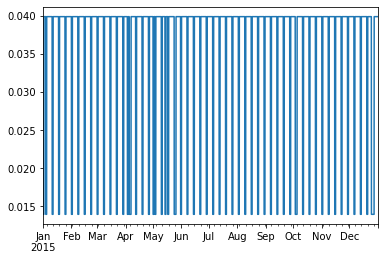

In [20]:
gas_industry_time["DEG0M", 8, "Prozesswärme"].plot()

### 1.2. mit Hilfe der bestehende heatmap funktion

Ergebnisse sind im 15min takt die bestehende Funtion arbeitet aber im 1h takt deswegen wird resamplet.

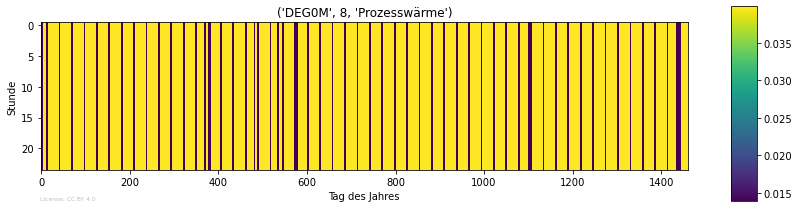

In [21]:
fig, ax = plot.heatmap_timeseries(gas_industry_time["DEG0M", 8, "Prozesswärme"])

In [22]:
gas_industry_hourly = gas_industry_time.resample("h").sum()
gas_industry_hourly.head()

LK                                  DEF01                                    \
WZ                                      6                                     
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 01:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 02:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 03:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 04:00:00                   0.0          0.0       0.0        0.0   

LK                                                                           \
WZ                                      8                                     
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 01:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 02:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 03:00:00                   0.0          0.0       0.0        0.0   
2015-01-01 04:00:00                   0.0          0.0       0.0        0.0   

LK                                  DEF02               ...     DEG0L  \
WZ                                      6               ...         8   
VW                  Mechanische \nEnergie Prozesswärme  ... Raumwärme   
2015-01-01 00:00:00                   0.0          0.0  ...   0.00083   
2015-01-01 01:00:00                   0.0          0.0  ...   0.00083   
2015-01-01 02:00:00                   0.0          0.0  ...   0.00083   
2015-01-01 03:00:00                   0.0          0.0  ...   0.00083   
2015-01-01 04:00:00                   0.0          0.0  ...   0.00083   

LK                                             DEG0M                         \
WZ                                                 6                          
VW                  Warmwasser Mechanische \nEnergie Prozesswärme Raumwärme   
2015-01-01 00:00:00        0.0                   0.0          0.0       0.0   
2015-01-01 01:00:00        0.0                   0.0          0.0       0.0   
2015-01-01 02:00:00        0.0                   0.0          0.0       0.0   
2015-01-01 03:00:00        0.0                   0.0          0.0       0.0   
2015-01-01 04:00:00        0.0                   0.0          0.0       0.0   

LK                                                                           \
WZ                                                 8                          
VW                  Warmwasser Mechanische \nEnergie Prozesswärme Raumwärme   
2015-01-01 00:00:00        0.0              0.001469     0.055833  0.005877   
2015-01-01 01:00:00        0.0              0.001469     0.055833  0.005877   
2015-01-01 02:00:00        0.0              0.001469     0.055833  0.005877   
2015-01-01 03:00:00        0.0              0.001469     0.055833  0.005877   
2015-01-01 04:00:00        0.0              0.001469     0.055833  0.005877   

LK                              
WZ                              
VW                  Warmwasser  
2015-01-01 00:00:00        0.0  
2015-01-01 01:00:00        0.0  
2015-01-01 02:00:00        0.0  
2015-01-01 03:00:00        0.0  
2015-01-01 04:00:00        0.0  

[5 rows x 3208 columns]

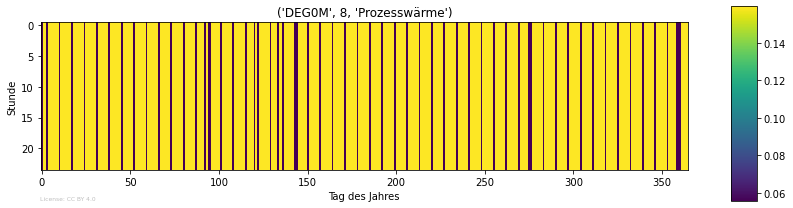

In [23]:
fig, ax = plot.heatmap_timeseries(gas_industry_hourly["DEG0M", 8, "Prozesswärme"])

## 2. Auswahl eines LK (-WZ Kombi)

### 2.1. mittels pyplot

In [24]:
def temporal_plot_function(df):
    fig, ax = plt.subplots(figsize=(20, 4))
    df.sum(axis = 1).plot(ax = ax, label = "Gesamt")
    for col in df:
        df[col].plot(ax = ax, label = col)
    plt.legend(loc = "upper left", bbox_to_anchor=(1.02, 0.9))
    return fig, ax

C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\IPython\core\interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


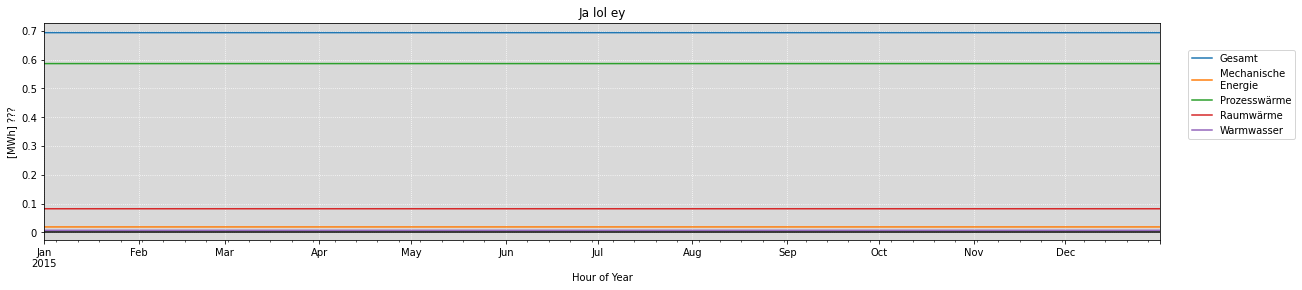

In [25]:
fig, ax = temporal_plot_function(gas_industry_time["DE300", 6])
plot.set_ax_format(ax=ax, ylabel='[MWh] ???', xlabel='Hour of Year',
                   axtitle='Ja lol ey')

### 2.2. mit der Heatmap

auch hier wird resamplet um verwerbare Ergebnisse zu erhalten

C:\Users\Fabian\anaconda3\envs\disaggregator\lib\site-packages\IPython\core\interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


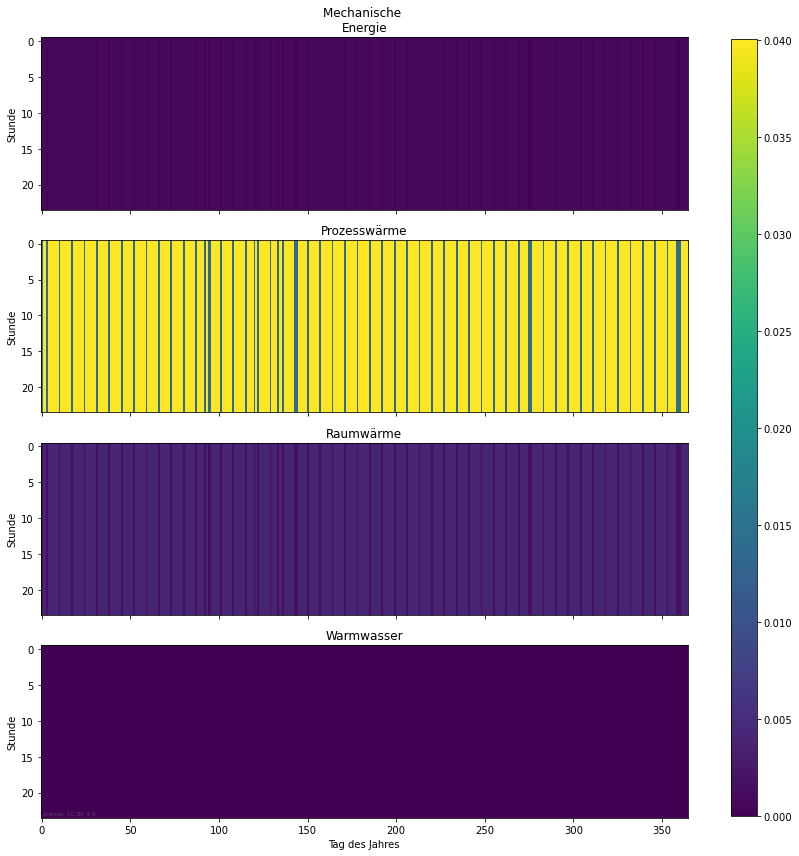

In [26]:
fig, ax = plot.heatmap_timeseries(gas_industry_hourly["DE300", 8])